BloomTech Data Science

*Unit 2, Sprint 2, Module 4*

---

In [2]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import pandas as pd

In [3]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/main/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Classification Metrics

This sprint, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions

The tasks for this project are as follows:

- **Task 1:** Use `wrangle` function to import training and test data.
- **Task 2:** Split training data into feature matrix `X` and target vector `y`.
- **Task 3:** Split training data into training and validation sets.
- **Task 4:** Establish the baseline accuracy score for your dataset.
- **Task 5:** Build `model`.
- **Task 6:** Calculate the training and validation accuracy score for your model.
- **Task 7:** Plot the confusion matrix for your model.
- **Task 8:** Print the classification report for your model.
- **Task 9:** Identify likely `'non-functional'` pumps in the test set.
- **Task 10:** Find likely `'non-functional'` pumps serving biggest populations.
- **Task 11 (`stretch goal`):** Plot pump locations from Task 10.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `plotly`
- `sklearn`


# I. Wrangle Data

In [4]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, 
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path, 
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(15).T.duplicated().index
                 if df.head(15).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)             

    return df

**Task 1:** Using the above `wrangle` function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

In [5]:
%time
df = wrangle(r'C:\Users\Alex Lucchesi\OneDrive\Documents\GitHub\Unit_2_Kaggle_Challenge\data\waterpumps\train_features.csv', r'C:\Users\Alex Lucchesi\OneDrive\Documents\GitHub\Unit_2_Kaggle_Challenge\data\waterpumps\train_labels.csv')
X_test = wrangle(r'C:\Users\Alex Lucchesi\OneDrive\Documents\GitHub\Unit_2_Kaggle_Challenge\data\waterpumps\test_features.csv')
df.head()
# X_test.head()

Wall time: 0 ns


,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,...,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,
69572.0,6000.0,1390.0,34.938093,-9.856322,NaN,Lake Nyasa,Iringa,11,5.0,109.0,...,annually,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
8776.0,NaN,1399.0,34.698766,-2.147466,NaN,Lake Victoria,Mara,20,2.0,280.0,...,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
34310.0,25.0,686.0,37.460664,-3.821329,NaN,Pangani,Manyara,21,4.0,250.0,...,per bucket,soft,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
67743.0,NaN,263.0,38.486161,-11.155298,NaN,Ruvuma / Southern Coast,Mtwara,90,63.0,58.0,...,never pay,soft,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
19728.0,NaN,NaN,31.130847,-1.825359,NaN,Lake Victoria,Kagera,18,1.0,NaN,...,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


# II. Split Data

**Task 2:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

**Note:** You won't need to do a train-test split because you'll use cross-validation instead.

In [6]:
target = 'status_group'
X = df.drop(columns = target)
y = df[target]

**Task 3:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state = 42)

# Double check split was done proper
assert len(X_train) + len(X_val) == len(X)

# III. Establish Baseline

**Task 4:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [8]:
baseline_acc = y_train.value_counts(normalize=True).max() *100
print('Baseline Accuracy Score:', round(baseline_acc, 4),'%')

Baseline Accuracy Score: 54.2583 %


In [9]:
y_train.value_counts()

functional                 25783
non functional             18264
functional needs repair     3472
Name: status_group, dtype: int64

Majority Class is Functional. To find percentage of training observations, we would do: percentage = functional / len(y_train). len(y_train) gives me the total number of observations.

In [10]:
percentage = 25783 / len(y_train)
print(round(percentage*100, 4), '%')

54.2583 %


# IV. Build Models

**Task 5:** Build and train your `model`. Include the transformers and predictor that you think are most appropriate for this problem.

In [11]:
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators = 25, n_jobs = -1, random_state = 42)
)

model.fit(X_train, y_train);

# V. Check Metrics

**Task 6:** Calculate the training and validation accuracy scores for `model`.

In [12]:
training_acc = model.score(X_train, y_train)
val_acc = model.score(X_val, y_val)

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.9920873755760854
Validation Accuracy Score: 0.8005892255892256


**Task 7:** Plot the confusion matrix for your model, using your validation data.

**Note:** Since there are three classes in your target vector, the dimensions of your matrix will be 3x3.

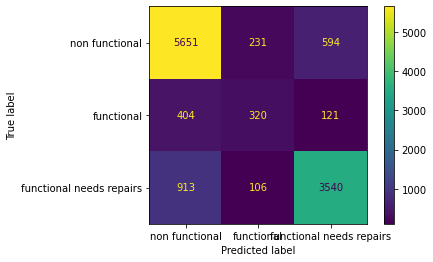

In [13]:
# Plot 3x3 confusion matrix
col = ['non functional','functional', 'functional needs repairs']
plot_confusion_matrix(
    model,
    X_val,
    y_val,
    values_format= '.0f',
    display_labels= col,
);

Calculating precision and recall for a multiclass problem is a bit of a mess. Fortunately, we can use `sklearn`'s classification report.

**Task 8:**  Print the classification report for your `model`, using your validation data.

In [14]:
# Print classification report
print(classification_report(y_val,
                            model.predict(X_val),
                            target_names = col))

                          precision    recall  f1-score   support

          non functional       0.81      0.87      0.84      6476
              functional       0.49      0.38      0.43       845
functional needs repairs       0.83      0.78      0.80      4559

                accuracy                           0.80     11880
               macro avg       0.71      0.68      0.69     11880
            weighted avg       0.80      0.80      0.80     11880



In [15]:
report = classification_report(y_val, 
                               model.predict(X_val),
                               target_names= col,
                               output_dict=True)

# Can index into dict. Can be used to pull any values.
precision = report['macro avg']['precision']
recall = report['macro avg']['recall']
f1 = report['macro avg']['f1-score']

fucntional_precision = report['functional']['precision']
print('Precision for the model is:', precision)
print('Recall Score for the model is:', recall)
print('f1 score for the model is:', f1)
print('Functional Precision for the model is:', fucntional_precision)

Precision for the model is: 0.7100059711388861
Recall Score for the model is: 0.6759302812034567
f1 score for the model is: 0.69001282771349
Functional Precision for the model is: 0.487062404870624


# VI. Tune Model

Usually, we use this part of the ML workflow to adjust the hyperparameters of the our model to increase performance based on metrics like accuracy. Today, we'll use it to help maximize the impact of our water pump repairs when resources are scarce. What if we only had funds to repair 100 water pumps?

(This activity is based on a [post](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050) by Lambda alum Michael Brady.)

**Task 9:** Using your model's `predict_proba` method, identify the observations in your **test set** where the model is more than 95% certain that a pump is `'non-functional'`. Put these observations in the DataFrame `X_test_nf`.

In [16]:
X_val

,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,...,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
37098.0,NaN,NaN,31.985658,-3.596360,NaN,Lake Tanganyika,Shinyanga,17,5.0,NaN,...,unknown,unknown,soft,good,dry,shallow well,shallow well,groundwater,other,other
14530.0,NaN,NaN,32.832815,-4.944937,NaN,Lake Tanganyika,Tabora,14,6.0,NaN,...,never pay,never pay,milky,milky,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
71755.0,1200.0,906.0,35.711743,-10.780539,NaN,Ruvuma / Southern Coast,Ruvuma,10,2.0,NaN,...,pay annually,annually,soft,good,enough,river,river/lake,surface,communal standpipe,communal standpipe
55610.0,5000.0,1270.0,35.794196,-7.485443,NaN,Rufiji,Iringa,11,1.0,1.0,...,pay annually,annually,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe
19821.0,NaN,1945.0,34.233402,-9.374240,NaN,Lake Nyasa,Iringa,11,3.0,NaN,...,never pay,never pay,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50523.0,200.0,1239.0,30.325354,-4.312807,NaN,Lake Tanganyika,Kigoma,16,2.0,1500.0,...,pay monthly,monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe
73846.0,NaN,NaN,32.799097,-5.018325,NaN,Lake Tanganyika,Tabora,14,6.0,NaN,...,pay per bucket,per bucket,soft,good,enough,dam,dam,surface,communal standpipe,communal standpipe
42110.0,NaN,NaN,33.865163,-3.331594,NaN,Internal,Shinyanga,17,2.0,NaN,...,other,other,soft,good,enough,shallow well,shallow well,groundwater,hand pump,hand pump


In [25]:
X_val

,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,...,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
37098.0,NaN,NaN,31.985658,-3.596360,NaN,Lake Tanganyika,Shinyanga,17,5.0,NaN,...,unknown,unknown,soft,good,dry,shallow well,shallow well,groundwater,other,other
14530.0,NaN,NaN,32.832815,-4.944937,NaN,Lake Tanganyika,Tabora,14,6.0,NaN,...,never pay,never pay,milky,milky,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
71755.0,1200.0,906.0,35.711743,-10.780539,NaN,Ruvuma / Southern Coast,Ruvuma,10,2.0,NaN,...,pay annually,annually,soft,good,enough,river,river/lake,surface,communal standpipe,communal standpipe
55610.0,5000.0,1270.0,35.794196,-7.485443,NaN,Rufiji,Iringa,11,1.0,1.0,...,pay annually,annually,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe
19821.0,NaN,1945.0,34.233402,-9.374240,NaN,Lake Nyasa,Iringa,11,3.0,NaN,...,never pay,never pay,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50523.0,200.0,1239.0,30.325354,-4.312807,NaN,Lake Tanganyika,Kigoma,16,2.0,1500.0,...,pay monthly,monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe
73846.0,NaN,NaN,32.799097,-5.018325,NaN,Lake Tanganyika,Tabora,14,6.0,NaN,...,pay per bucket,per bucket,soft,good,enough,dam,dam,surface,communal standpipe,communal standpipe
42110.0,NaN,NaN,33.865163,-3.331594,NaN,Internal,Shinyanga,17,2.0,NaN,...,other,other,soft,good,enough,shallow well,shallow well,groundwater,hand pump,hand pump


In [21]:
y_val

id
37098.0    non functional
14530.0        functional
71755.0        functional
55610.0        functional
19821.0        functional
                ...      
50523.0        functional
73846.0        functional
42110.0        functional
20061.0        functional
25579.0        functional
Name: status_group, Length: 11880, dtype: object

In [26]:
data

{'y_val': id
 37098.0    non functional
 14530.0        functional
 71755.0        functional
 55610.0        functional
 19821.0        functional
                 ...      
 50523.0        functional
 73846.0        functional
 42110.0        functional
 20061.0        functional
 25579.0        functional
 Name: status_group, Length: 11880, dtype: object,
 'y_pred_proba': array([0.  , 0.56, 1.  , ..., 1.  , 0.28, 0.56])}

In [24]:
data = {'y_val': y_val,
        'y_pred_proba': model.predict_proba(X_val)[:,0]}
X_test_nf = pd.DataFrame(data)
threshold = .95
mask = X_test_nf['y_pred_proba'] > threshold
X_test_nf = X_test_nf[mask]
X_test_nf

,y_val,y_pred_proba
id,,
71755.0,functional,1.00
19821.0,functional,1.00
25975.0,functional,1.00
52838.0,functional,1.00
42806.0,functional,1.00
...,...,...
42015.0,functional,0.96
27906.0,non functional,1.00
50523.0,functional,1.00


**Task 10:** Limit `X_test_nf` to the 100 pumps with the largest associated populations.

In [18]:
final = X_test_nf.merge(df, right_index= True, left_index= True)
plot = final.sort_values(by = 'population').head(100)
plot

,y_val,y_pred_proba,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,...,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,
5182.0,non functional,0.96,NaN,118.0,39.148467,-7.658081,NaN,Rufiji,Pwani,60,...,never pay,soft,good,seasonal,dam,dam,surface,communal standpipe multiple,communal standpipe,non functional
1190.0,non functional,0.96,NaN,1403.0,37.610941,-3.144554,NaN,Pangani,Kilimanjaro,3,...,never pay,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,non functional
55473.0,non functional,1.00,NaN,243.0,39.125787,-10.429525,NaN,Ruvuma / Southern Coast,Mtwara,90,...,never pay,soft,good,dry,spring,spring,groundwater,communal standpipe multiple,communal standpipe,non functional
21952.0,non functional,0.96,NaN,1757.0,37.493720,-3.253344,NaN,Pangani,Kilimanjaro,3,...,never pay,soft,good,enough,spring,spring,groundwater,other,other,non functional
49933.0,non functional,1.00,NaN,1427.0,34.501954,-4.825662,NaN,Internal,Singida,13,...,unknown,unknown,unknown,dry,shallow well,shallow well,groundwater,other,other,non functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56566.0,non functional,1.00,NaN,1523.0,34.744543,-5.031195,NaN,Internal,Singida,13,...,unknown,soft,good,dry,shallow well,shallow well,groundwater,other,other,non functional
8334.0,non functional,0.96,NaN,1706.0,37.493785,-3.259454,NaN,Pangani,Kilimanjaro,3,...,never pay,soft,good,enough,spring,spring,groundwater,other,other,non functional
2538.0,non functional,1.00,3000.0,894.0,35.395640,-7.651388,NaN,Rufiji,Iringa,11,...,annually,soft,good,dry,spring,spring,groundwater,communal standpipe,communal standpipe,non functional


# VII. Communicate Results

**Task 11 (`stretch goal`):** Create a scatter plot with the location of the 100 pumps in `X_test_nf`.

**Note:** If you want to make this a **`super stretch goal`**, create a Mapbox scatter plot using [Plotly](https://plotly.github.io/plotly.py-docs/generated/plotly.express.scatter_mapbox.html).

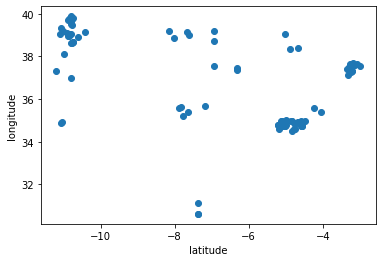

In [19]:
import matplotlib.pyplot as plt
plt.scatter(plot['latitude'], plot['longitude'])
plt.xlabel('latitude')
plt.ylabel('longitude');

In [20]:
import plotly.express as px

fig = px.scatter_mapbox(plot, lat = plot.latitude, lon = plot.longitude, color = plot.status_group)
fig.update_layout(mapbox_style = 'white-bg')
fig.show()